In [1]:
import os
import sys
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import the Modules dir
project_path = "<PATH-TO-REPO>/BiMAEB-UDD-RUL/"
sys.path.insert(0, project_path)

from Modules.Models import RULNeuralNetwork
from experimental_results.functions import (normalize_df,
                                            view_RUL_stats,
                                            view_performance_on_data,
                                            get_model_rul_predictions,
                                            get_scores,
                                            get_mse,
                                            plot_unit_recon_error_and_threshold,
                                            plot_rul_predictions_and_targets,
                                            normalize_df_with_context,
                                            TURBOFAN_FEATURES_LIST)

In [2]:
normal_op_len = 45
norm_op_len_as_pct = True

dataset = "FD001"
model_type = "AE"
prefix = "Pct" if norm_op_len_as_pct else "Len"


print(f"Normality: {normal_op_len} {prefix}")

Normality: 45 Pct


In [10]:
model_name = f"normOp{prefix}{normal_op_len}_RUL_{model_type}"

path_to_training_data_dir = "<PATH-TO-DATA-DIR>/NASA_turbofan_data/train"
path_to_testing_data_dir = "<PATH-TO-DATA-DIR>/NASA_turbofan_data/validation"

# Define file names
csv_file_training = f"{dataset}_train_unsupervised_labels_AutoEncoder_Op{prefix}{normal_op_len}.csv"
csv_file_testing = f"{dataset}_test_unsupervised_labels_AutoEncoder_Op{prefix}{normal_op_len}.csv"

# Define paths
dataset_path_training = os.path.join(path_to_training_data_dir, csv_file_training)
dataset_path_testing = os.path.join(path_to_testing_data_dir, csv_file_testing)

path_to_model_state_dict = f"models/{model_name}_model_state_dict"

print(f"Model Path: {path_to_model_state_dict}")

Model Path: models/normOpPct45_RUL_AE_model_state_dict


In [11]:
# Read original data
print(f"Reading dataset: \n{dataset_path_testing}\n")
print(f"Reading dataset: \n{dataset_path_training}")

df_testing_not_normalized = pd.read_csv(dataset_path_testing)
df_training_not_normalized = pd.read_csv(dataset_path_training)

Reading dataset: 
/Users/rafaeltoche/Documents/School/Research/Rainwaters_Lab/DART-LP2/Condition_Monitoring/data/NASA_turbofan_data/validation/FD001_test_unsupervised_labels_AutoEncoder_OpPct45.csv

Reading dataset: 
/Users/rafaeltoche/Documents/School/Research/Rainwaters_Lab/DART-LP2/Condition_Monitoring/data/NASA_turbofan_data/train/FD001_train_unsupervised_labels_AutoEncoder_OpPct45.csv


In [12]:
print("Normalizing datasets...\n")

# Normalize testing data using training data as the context.
df_testing_normalized = normalize_df_with_context(df=df_testing_not_normalized,
                                                  df_context=df_training_not_normalized,
                                                  model_features=TURBOFAN_FEATURES_LIST)

Normalizing datasets...



In [13]:
# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using Device: {}".format(device))

Using Device: cpu


In [14]:
window_size = 1
metrics_dir = "model"
ts_number_features = len(TURBOFAN_FEATURES_LIST)
latent_size = 16

print(f"Normality Length: {normal_op_len}")
print(f"Latent Size: {latent_size}")
print(f"Number ts features: {ts_number_features}")

Normality Length: 45
Latent Size: 16
Number ts features: 24


In [15]:
model = RULNeuralNetwork(ts_number_features=ts_number_features,
                         device=device,
                         model_name="",
                         metrics_dir=metrics_dir)

print(f"Reading model at '{path_to_model_state_dict}'")
model.load_state_dict(torch.load(path_to_model_state_dict, map_location=torch.device(device)))

Reading model at 'models/normOpPct45_RUL_AE_model_state_dict'


<All keys matched successfully>

In [16]:
view_performance_on_data(model=model, 
                         df=df_testing_normalized, 
                         identifier_col="unit", 
                         cycle_col="cycle", 
                         rul_col="RUL",
                         fault_col="fault")

Computing RUL for Unit 1 (on cycle=31)
Target: 112 --> Pred.:  129

Computing RUL for Unit 2 (on cycle=49)
Target: 98 --> Pred.:  130

Computing RUL for Unit 3 (on cycle=126)
Target: 69 --> Pred.:  67

Computing RUL for Unit 4 (on cycle=106)
Target: 82 --> Pred.:  97

Computing RUL for Unit 5 (on cycle=98)
Target: 91 --> Pred.:  102

Computing RUL for Unit 6 (on cycle=105)
Target: 93 --> Pred.:  82

Computing RUL for Unit 7 (on cycle=160)
Target: 91 --> Pred.:  106

Computing RUL for Unit 8 (on cycle=166)
Target: 95 --> Pred.:  78

Computing RUL for Unit 9 (on cycle=55)
Target: 111 --> Pred.:  97

Computing RUL for Unit 10 (on cycle=192)
Target: 96 --> Pred.:  102

Computing RUL for Unit 11 (on cycle=83)
Target: 97 --> Pred.:  34

Computing RUL for Unit 12 (on cycle=217)
Target: 124 --> Pred.:  89

Computing RUL for Unit 13 (on cycle=195)
Target: 95 --> Pred.:  80

Computing RUL for Unit 14 (on cycle=46)
Target: 107 --> Pred.:  74

Computing RUL for Unit 15 (on cycle=76)
Target: 83 -->

Predicted 48 Samples in unit 100
Score: 50.842612191761035
MSE: 85.10157208991495


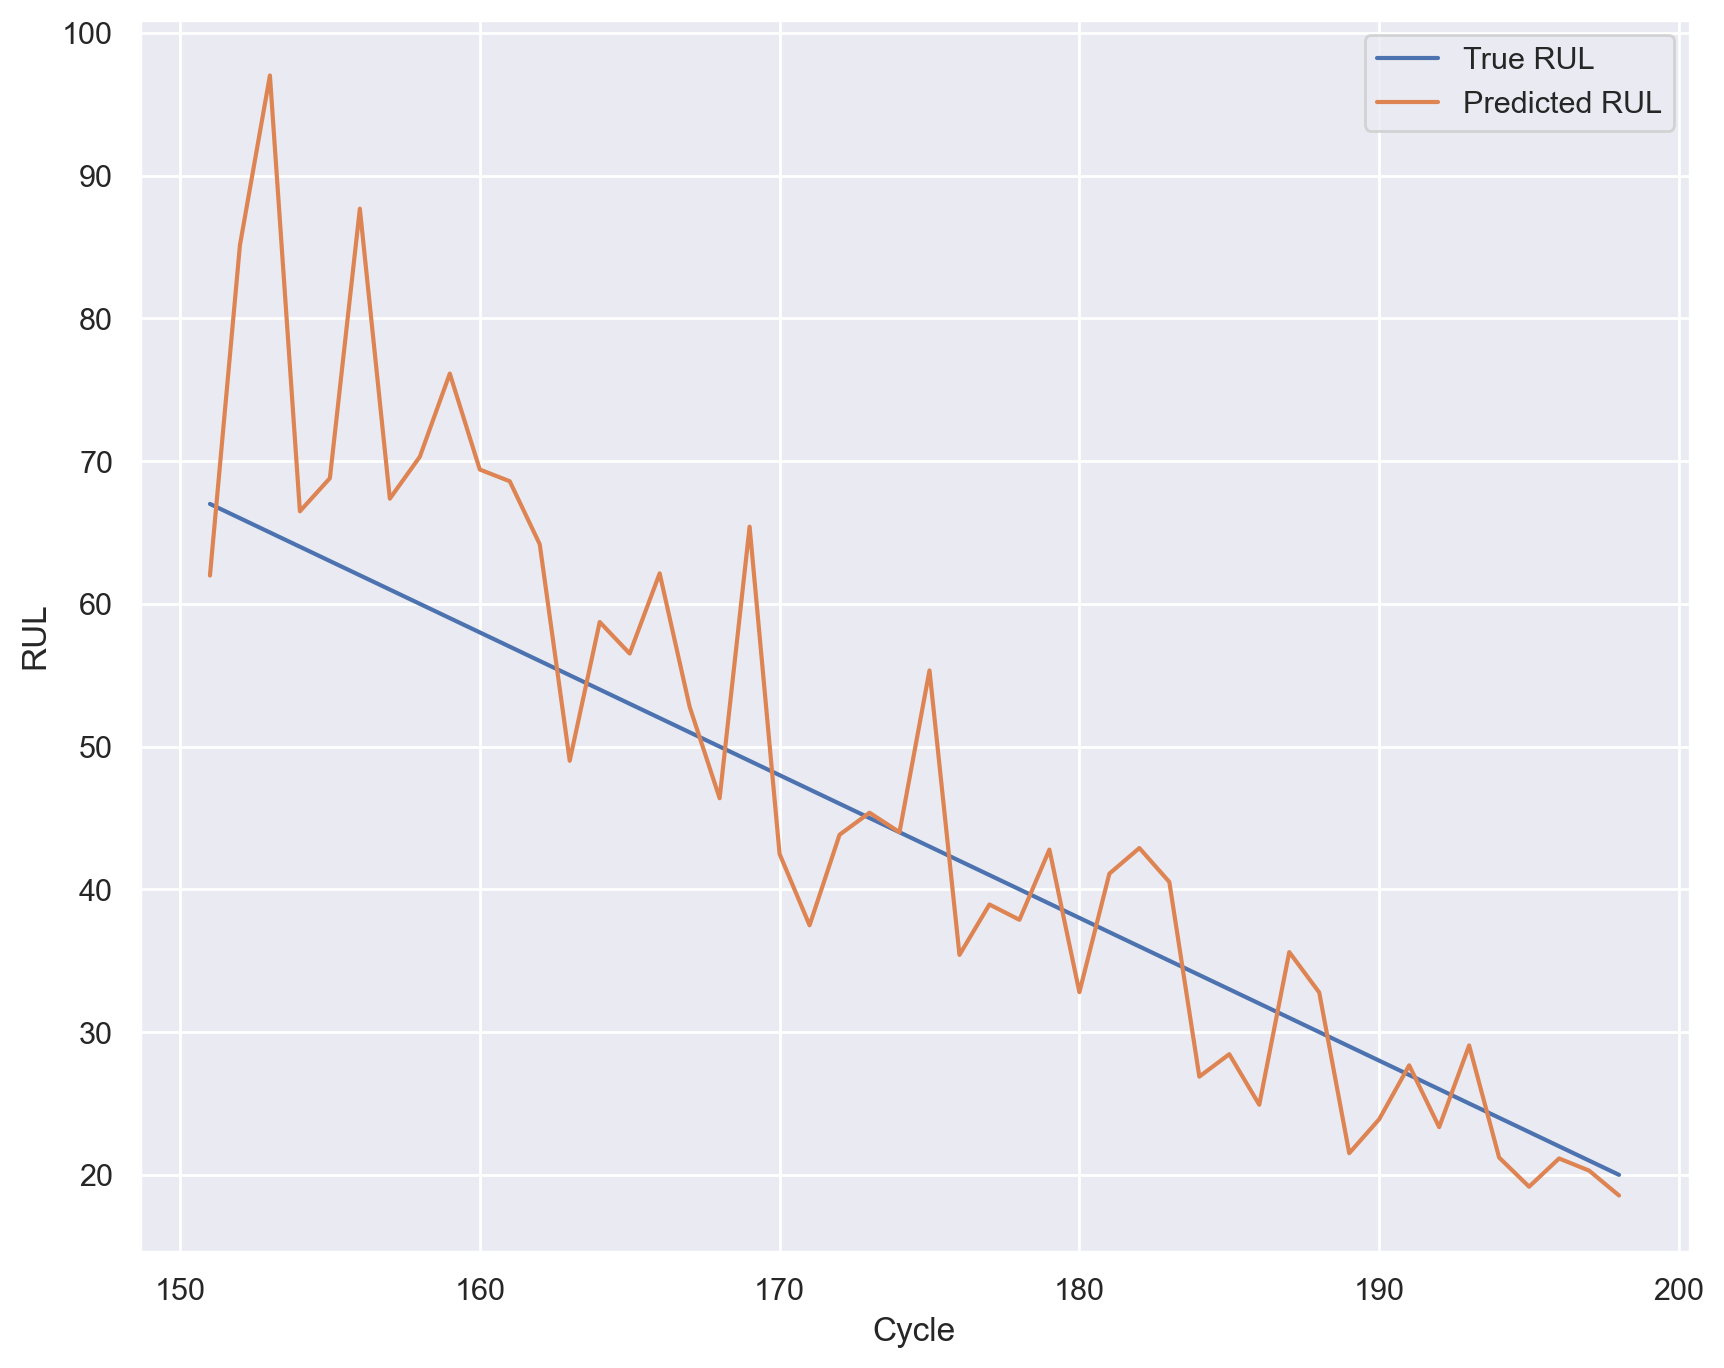

In [17]:
unit = 100
query_faults = True

df_unit = df_testing_normalized.query(f"unit=={unit}")
if query_faults:
    df_unit = df_unit.query("fault==1")
features = df_unit[TURBOFAN_FEATURES_LIST].to_numpy()
targets = df_unit["RUL"].to_numpy()
cycles = df_unit["cycle"].to_numpy()

rul_predictions = get_model_rul_predictions(model, features)
print(f"Predicted {len(rul_predictions)} Samples in unit {unit}")
plot_rul_predictions_and_targets(rul_predictions, targets=targets, cycles=cycles)